# Play by Play NFL Analysis of the 2015 season

By Adam Baca, Zoheb Allam, Scott Gozdzialski, Ethan Graham, 

### Business Understanding


The National Football League (NFL) is a $62.9 billion industry with each team on average being worth around $2 billion. This make it worth almost the equivalent of the 30 Major League Baseball teams and 30 NBA teams combined. As its value continues to increase, executives around the NFL are searching for the best way to not only improve their team's value but also to improve their teams efficiency and success on the field. Many NFL executives have seen the success data analytics has had on improving baseball teams and analytics departments have become more prevelant in the NFL. 

However, while data analytics within the NFL has grown there is a lack of publicly available data which researchers can use. Therefore, researchers at Carnegie Mellon University built an R package that used an API maintained by the NFL and scraped data on individual plays which occured in the 2015 season. The data set contains information on the players involved in each play, yards gained, the type of play, whether or not it resulted in a td, etc. We eventually plan to use the data to develop a predictive model examining yards gained on each play to determine the best predictors. Hypothetically teams would be able to use our model to determine the factors they should consider before calling a play such as whether to run or throw the ball. In order to determine the effectiveness of our algorithm, we will use the adjusted r squared to determine the amount of variance explained by the model. 

### Data Meaning Type

In [22]:
import numpy as np
import pandas as pd
url = 'https://raw.githubusercontent.com/agbaca/DataMiningFall17/master/NFLPlaybyPlay2015.csv'
df = pd.read_csv(url,index_col=0,parse_dates=[0])

df.drop(['desc','PlayAttempted','sp','DefTwoPoint','PuntResult','Passer','Interceptor'],axis=1, inplace=True)
df.drop(['Rusher','Receiver','Returner','Tackler1','Tackler2','RecFumbPlayer','PenaltyType'],axis=1, inplace=True)
df.drop(['PenalizedPlayer','Season','time','TimeUnder','PlayTimeDiff','yrdln'],axis=1, inplace=True)
df.drop(['BlockingPlayer','GoalToGo','FirstDown','Safety','Sack','RunGap','Reception'],axis=1, inplace=True)
df.drop(['ReturnResult','PassOutcome'],axis=1, inplace=True)

df['GameID+DriveID'] = df.GameID.astype(str).str.cat(df.Drive.astype(str), sep='d')

The NFL 2015 dataset originally had over 65 different attributes per row.  Many of them are duplicates or are not need for our analysis. Our focus being on the team stats and not on individual stats we dropped any player specific attributes.

The variables we focused on are on 39 different columns that are most realated to the yards gained and ultimately to drive result.  

*Note some of the columns are kept at this point to give away of combining the data for cluster analysis

The 39 different columns are below.


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46129 entries, 36 to 39949
Data columns (total 39 columns):
Date                  46129 non-null object
GameID                46129 non-null int64
Drive                 46129 non-null int64
qtr                   46129 non-null int64
down                  39006 non-null float64
TimeSecs              46102 non-null float64
SideofField           46063 non-null object
yrdline100            46021 non-null float64
ydstogo               46129 non-null int64
ydsnet                46129 non-null int64
posteam               42878 non-null object
DefensiveTeam         42878 non-null object
Yards.Gained          46129 non-null int64
Touchdown             46129 non-null int64
ExPointResult         1131 non-null object
TwoPointConv          89 non-null object
PlayType              46129 non-null object
PassAttempt           46129 non-null int64
PassLength            19291 non-null object
PassLocation          19291 non-null object
InterceptionThrown 

The columns for this analysis are 


|Column name          |Description                                      |Values
|---------------------|:-----------------------------------------------:|:-------------------------------------:|
|Date                 |Date of game                                     |Date
|GameID               |Unique game ID                                   |Interger
|Drvie                |The way to id which drive it is in the game      |Interger
|qtr                  |Quarter of the game                              |1-4
|down                 |Which of the four downs                          |1-4, Na
|Timesecs             |Total game time left in seconds                  |3600 - 0
|SideofField          |Which side of the field the ball is on           |Team Code
|yrdline100           |How far the ball is from the endzone             |0-100
|ydrtogo              |Yards to go before a first down                  |28-1
|ydsnet               |total yards gained in the drive                  |0-100
|Posteam              |Team with the ball                               |Team Code
|DefensiveTeam        |Team Defending                                   |Team Code
|Touchdown            |If the posteam made a touchdown                  |0, 1
|ExPointResults       |If the extra point was made                      |0, 1
|TwoPointConv         |If the posteam made a2 point conversion          |0, 1
|PlayType             |What type of play it was                         |Listed Below
|PassLength           |Where the pass was thrown                        |Short, Deep, NA          
|PassLocation         |Location of pass on field                        |Left, Righ, Middle, NA 
|InterceptionThrown   |Was the ball intercepted                         |0, 1
|RunLocation          |Location of the run                              |Left, right, Middle, NA   
|FieldGoalResult      |If the field goal was made                       |Good, No Good ,NA 
|FieldGoalDistance    |How far the field goal attemp was                |50-0 
|Fumble               |If there was a fumble on the play                |0 , 1
|RecFumbTeam          |Team that recover the fumbel                     |Team code 
|Challenge.Replay     |If the play ws challenged by the coach           |0, 1
|ChalReplayResult     |Challenge Result                                 |Reversed, Upheld, NA 
|Accepted.Penalty     |If the Penaly was accepted by the team           |0, 1
|PenalizedTeam        |Team that was penalized                          |Team Code
|Penalty.Yards        |Yard of the penalty                              |0 - 15
|PosTeamScore         |Possetion team score                             |Integer
|DefTeamScore         |Defending team score                             |Integer
|ScoreDiff            |The difference between posteam/defteam score     |positive and negative integer
|AbsScoreDiff         |The absolute value of score diff                 |Integer
|HomeTeam             |The home team for the game                       |Team Code
|Away                 |The Away team for the game                       |Team Code
|GameID+DriveID       |Combined GameID and drive ID                     |Integer

The Team Codes are listed below

NE, PIT, GB, CHI, MID, HOU, KC, CLE, NYJ, BUF, IND, MIA, WAS, CAR, JAC, STL, SEA, NO, ARI, SD, DET, TB, TEN,CIN, OAK, DEN, BAL, NYG, DAL,ATL, PHI, MIN, SF

PLay Type

Pass, Run, Kick off, Field Goal,Punt, Sack, No Play,QB Kneel, Two minute warning, Timout, Onside Kick,End of Game, Quarter ended
extra point 

### Data Quality

There are many missing values in the different fields, as can be seen above, because many of the fields are binary flags with 0 for failed, 1 for success, and NA for not attempted. As we progress with the analysis we might need to keep or remove some of these, therefore we are not looking to change any of these at this point.

There are no outliers because every column has discrete ranges associated with them, i.e. there are only 4 down, there is only 100 yards on the field, there are only so many play types, etc. The exceptions to this rule would be the fields marked with integer but they can only be an integer and have a top and bottom range.


### Simple Statistics

In [5]:
df.describe()

,GameID,Drive,qtr,down,TimeSecs,yrdline100,ydstogo,ydsnet,Yards.Gained,Touchdown,...,RushAttempt,FieldGoalDistance,Fumble,Challenge.Replay,Accepted.Penalty,Penalty.Yards,PosTeamScore,DefTeamScore,ScoreDiff,AbsScoreDiff
count,4.612900e+04,46129.000000,46129.000000,39006.000000,46102.000000,46021.000000,46129.000000,46129.000000,46129.000000,46129.000000,...,46129.000000,989.000000,46129.000000,46129.000000,46129.000000,46129.000000,42878.000000,42878.00000,42878.000000,42878.000000
mean,2.015164e+09,12.279607,2.583407,1.996949,1686.735847,49.411312,7.310152,26.672289,4.885538,0.029309,...,0.284181,38.166835,0.013592,0.008953,0.076633,0.652388,10.586408,11.65024,-1.063832,7.773100
std,2.183164e+05,7.144244,1.134256,1.003834,1065.494471,24.852971,4.920808,25.379980,8.965909,0.168673,...,0.451028,10.337203,0.115792,0.094198,0.266011,2.716825,9.495190,9.96655,10.716223,7.452965
min,2.015091e+09,1.000000,1.000000,1.000000,-747.000000,1.000000,0.000000,-48.000000,-34.000000,0.000000,...,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-41.000000,0.000000
25%,2.015101e+09,6.000000,2.000000,1.000000,759.000000,31.000000,3.000000,5.000000,0.000000,0.000000,...,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.00000,-7.000000,3.000000
50%,2.015111e+09,12.000000,3.000000,2.000000,1800.000000,50.000000,9.000000,20.000000,1.000000,0.000000,...,0.000000,39.000000,0.000000,0.000000,0.000000,0.000000,9.000000,10.00000,0.000000,6.000000
75%,2.015121e+09,18.000000,4.000000,3.000000,2579.000000,71.000000,10.000000,45.000000,7.000000,0.000000,...,1.000000,47.000000,0.000000,0.000000,0.000000,0.000000,17.000000,17.00000,5.000000,11.000000
max,2.016010e+09,33.000000,5.000000,4.000000,3600.000000,99.000000,42.000000,99.000000,99.000000,1.000000,...,1.000000,66.000000,1.000000,1.000000,1.000000,55.000000,52.000000,51.00000,41.000000,41.000000


We start with a basic function giving the count, mean, std, min, 25%, 50% or median, 75%, and max.  we can see some attributes who have les the complete count, like down, that we would not expect.  For down it is because kick offs are NA, TimeSecs is because negative numbers are used for overtime and all games end in zero throwing off the count function. Field Goal distance is because the non-FG plays are NA.  Also, at the end of the quarter and timeouts cause problems with the scores and a few other attributes, but we are keeping them in to see if they provide any insight.

We will be looking at a box plot of yards.gain, a count of playtype, touchdown, Interception, and downs.


In [6]:
df['PlayType'].value_counts()

Pass                  18323
Run                   13109
No Play                2608
Kickoff                2565
Punt                   2443
Timeout                1859
Sack                   1191
Extra Point            1126
Field Goal              988
Quarter End             675
Two Minute Warning      481
QB Kneel                425
End of Game             211
Onside Kick              67
Spike                    52
Half End                  6
Name: PlayType, dtype: int64

In [7]:
df['Touchdown'].value_counts()

0    44777
1     1352
Name: Touchdown, dtype: int64

In [107]:
df['InterceptionThrown'].value_counts()

0    45661
1      468
Name: InterceptionThrown, dtype: int64

In [8]:
df['down'].value_counts()

1.0    15703
2.0    11728
3.0     7566
4.0     4009
Name: down, dtype: int64

### Visualize Atttibutes

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

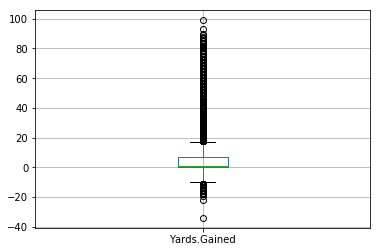

In [8]:
df.boxplot(column='Yards.Gained')

Examination of the yards gained boxplot above indicates that 50% of the values lie between 0 and approximately 10. We can also see that the distribution is skewed to the right and there are several outliers present, both above and below the interquartile range. This tells us that accounting for negative plays, the median yards gained when examining all the plays in 1 season is 0.  

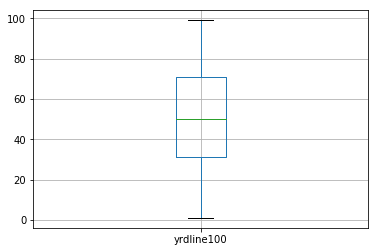

In [9]:
df.boxplot(column='yrdline100')

From the above box and whisker plot we can see that the median yard line plays began on was the 50 yard line. 50% of plays began between approximately the 35 yard line and the opponents 30 yard line (indicated by a value of 70 in the data file). In general we also see a normal distribution and as expected no outliers as an nfl field is confined to only 100 yards.    

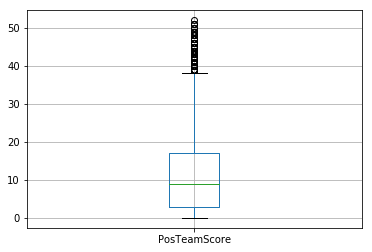

In [10]:
df.boxplot(column='PosTeamScore')

The above boxplot indicates that 50% of the plays that took place in the 2015 season occured when the offense had scored between 5 to 15 points. In addition, we see some outliers were the offenses had already scored more than 35 points when they ran a play.  

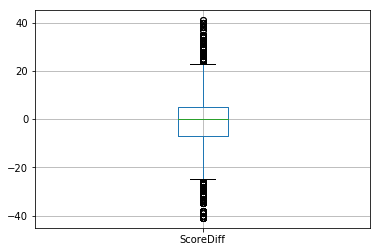

In [11]:
df.boxplot(column='ScoreDiff')

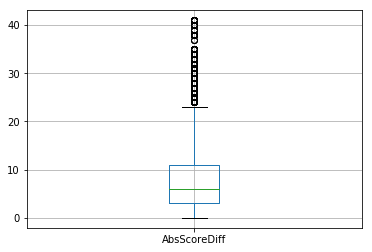

In [12]:
df.boxplot(column='AbsScoreDiff')

The two box plots above indicate the score differential when a play was run. The first box plot shows the score differential when considering both the perspective of the team that was ahead and behind. In essence they show duplicate results which is why the box plot is a perfect mirror if you split at the median value. Instead, the better plot to interpret is the absolute score differential shown directly beneath the score differential plot. We can see that the median play occured with a score differential of about 5. We can also see several outliers where the score differential was above 25.  

### Explore Joint Attributes and Class

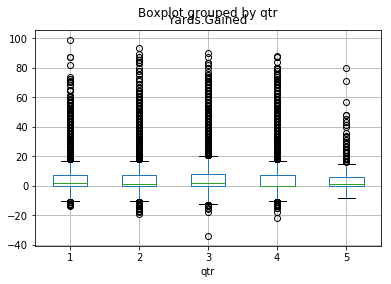

In [13]:
df.boxplot (column='Yards.Gained', by='qtr')

We also wanted to see if plays that resulted in a touchdown had more yards per gain as shown in the boxplot above. As expected, the median yards per gain on plays that resulted in a touchdown was higher. In addition, plays that resulted in a touchdown had a greater interquartile range and more variance compared to plays that did not result in a touchdown.  

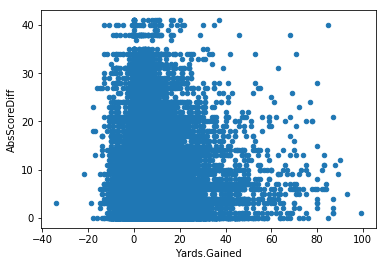

In [14]:
df.plot('Yards.Gained', 'AbsScoreDiff', kind='scatter')

We were also curious if a correlation existed between yards gained and the absolute score difference with the assumption that as the score differential increased, the yards gained on each play would also increase as teams became more offensive minded. While we don't see a clear positive trend, we can see that for many of the plays the greater the score differential the greater the yards gained as well.   

# Explore Joint Attributes

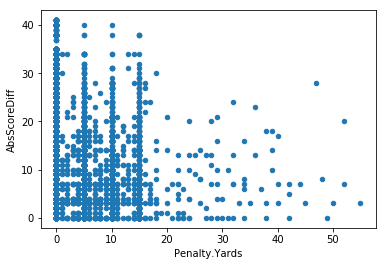

In [15]:
df.plot('Penalty.Yards', 'AbsScoreDiff', kind='scatter')

The scatterplot above indicates that the majority of plays that resulted in less than a 20 yard penalty occured when the score difference was below 20. In addition, the pattern of the values does not indicate a linear relationship.

In [19]:
pd.crosstab(df.InterceptionThrown, df.PassAttempt) 

PassAttempt,0,1
InterceptionThrown,,
0,26692,18969
1,0,468


A crosstabs was conducted to determine how many pass attempts thrown in a season resulted in an interception. As shown above, 468 throws (2.4%) of a total 19,437 throws attempted in the 2015 season resulted in an interception.  

In [20]:
pd.crosstab(df.Touchdown, df.PassAttempt) 

PassAttempt,0,1
Touchdown,,
0,26263,18514
1,429,923


Another crosstabs was conducted to determine how many pass attempts resulted in a touchdown. The table above indicates that 923 passes resulted in a touchdown, approximately 4.8% of the total 19,437 passes attempted in the 2015 season.

In [21]:
pd.crosstab(df.Fumble, df.RushAttempt) 

RushAttempt,0,1
Fumble,,
0,32634,12868
1,386,241


We were also interested in determining how many rushing attempts resulted in a fumble over the course of the 2015 season. As shown above, 241 rushes (1.8%) resulted in a fumble of the total 13,109 rushes attempted. We found it interesting that more passes were thrown in a single season than rush attempts.  

### New Features

### Exceptional Work